# **Movie Recommendation System**

In this project, we will build a Movie Recommendation System using the MovieLens 100K dataset.
The system will provide personalized recommendations to users by applying different recommendation strategies, such as:
*   User-based Collaborative Filtering
*   Item-based Collaborative Filtering
*   Matrix Factorization (SVD)

We will also evaluate the models using metrics like Precision@K and RMSE to measure their effectiveness.

### **🔧 Step 1: Setup**

In this step, we install the required Python libraries and import the necessary modules.



*   kagglehub → to easily download datasets from Kaggle
*   scikit-learn → for similarity computation and evaluation metrics
*   numpy, pandas → for data handling and preprocessing
*   matplotlib, seaborn → for visualization
*   svds (from SciPy) → for matrix factorization

This ensures our environment is ready before loading and exploring the dataset.

In [1]:
# Cell 1 — setup
# Install required libraries
!pip install -q kagglehub
!pip install -U scikit-learn

import os, glob, zipfile
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print("Ready. NumPy version:", np.__version__, "Pandas version:", pd.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 90.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Ready. NumPy version: 2.0.2 Pandas version: 2.2.2


### **📂 Step 2: Download the MovieLens 100K Dataset**

We will use the MovieLens 100K dataset, a classic benchmark dataset for building and evaluating recommendation systems.



*   The dataset contains 100,000 ratings (1–5) given by 943 users on 1,682 movies.
*   It also includes metadata like movie titles and genres.

In this step:



1.   We download the dataset directly from the GroupLens website.
2.   Unzip the compressed file into a working directory.
3.   Verify that the required files (u.data, u.item, etc.) are extracted successfully.

✅ After running this cell, you should see a list of files inside the ml-100k folder.

In [2]:
# Cell 2 — download MovieLens 100K
# Download MovieLens 100k dataset
!wget -q --show-progress http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip
print("Files in ml-100k folder:", sorted(os.listdir("ml-100k"))[:20])


ml-100k.zip         100%[===================>]   4.70M  9.17MB/s    in 0.5s    
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         
Fi

### **Step 3: Load Ratings & Movies**

*   u.data → user ratings (userId, movieId, rating, timestamp)
*   u.item → movie details (title, release date, genres, etc.)

These two files will give us:

*   ratings → who rated what
*   movies → movie info (names + genres)



In [3]:
# Cell 3 — load ratings and movies
ratings_cols = ["userId", "movieId", "rating", "timestamp"]
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=ratings_cols, encoding="latin-1")

movies_cols = ["movieId", "title", "release_date", "video_release_date", "IMDb_URL", "unknown",
               "Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama",
               "Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller",
               "War","Western"]
movies = pd.read_csv("ml-100k/u.item", sep="|", names=movies_cols, encoding="latin-1")


### **Step 4: Exploratory Data Analysis (EDA)**

*   Count unique users & movies
*   Check rating distribution
*   Plot histogram of ratings
*   Find Top 10 most-rated movies

Unique users: 943
Unique movies: 1682
Ratings distribution:
 rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64


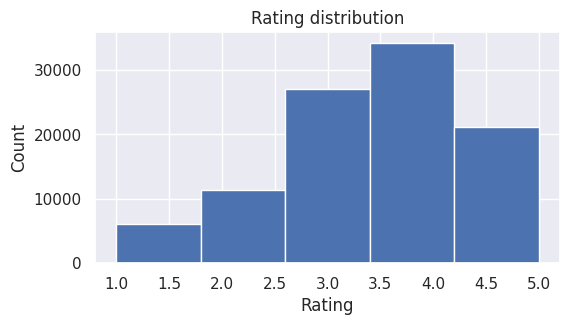

,movieId,count,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,50,583,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,...,0,0,0,0,0,1,1,0,1,0
1,258,509,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,100,508,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,...,0,0,0,0,0,1,1,0,1,0
4,294,485,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,286,481,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
6,288,478,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
7,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,300,431,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
9,121,429,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [4]:
# Cell 4 — basic EDA
print("Unique users:", ratings.userId.nunique())
print("Unique movies:", ratings.movieId.nunique())
print("Ratings distribution:\n", ratings.rating.value_counts().sort_index())

plt.figure(figsize=(6,3))
ratings.rating.hist(bins=5)
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Top 10 most-rated movies
top10 = ratings.groupby("movieId").size().sort_values(ascending=False).head(10).reset_index(name="count")
top10 = top10.merge(movies, on="movieId", how="left")
top10


### **Step 5: Train/Test Split (Leave-One-Out)**

*   For each user → hold out 1 rating as test
*   Remaining ratings → training set
*   Ensures every user is represented in train & test

In [5]:
# Cell 5 — leave-one-out: hold out one rating per user for testing
def leave_one_out(ratings_df, seed=42):
    np.random.seed(seed)
    test_indices = []
    for user, group in ratings_df.groupby("userId"):
        # sample one index per user
        idx = group.sample(n=1, random_state=seed).index[0]
        test_indices.append(idx)
    test = ratings_df.loc[test_indices].reset_index(drop=True)
    train = ratings_df.drop(index=test_indices).reset_index(drop=True)
    return train, test

train_ratings, test_ratings = leave_one_out(ratings)
print("Train shape:", train_ratings.shape, "Test shape:", test_ratings.shape)
test_ratings.head()


Train shape: (99057, 4) Test shape: (943, 4)


,userId,movieId,rating,timestamp
0,1,31,3,875072144
1,2,100,5,888552084
2,3,330,2,889237297
3,4,50,5,892003526
4,5,367,3,875636281


### **Step 6: User–Item Matrix**

*   Pivot train ratings → users × movies matrix
*   Rows = users, Columns = movies, Values = ratings
*   Sorted for consistency

In [6]:
# Cell 6 — user-item matrix (train)
R_train = train_ratings.pivot(index='userId', columns='movieId', values='rating')
R_train = R_train.sort_index().sort_index(axis=1)  # consistent ordering
user_ids = list(R_train.index)
item_ids = list(R_train.columns)
R_train.shape


(943, 1682)

### **Step 7: Prepare Data for Similarity**

*   Convert ratings to NumPy array
*   mask_rated: tracks where ratings exist
*   Compute user mean ratings
*   Create demeaned matrix (ratings − user mean) for similarity

In [7]:
# Cell 7 — prepare matrices and masks
R = R_train.values.astype(float)   # numpy array with NaN for missing
mask_rated = ~np.isnan(R)          # True where rating exists
user_means = np.nanmean(R, axis=1)              # mean rating per user (NaN handled)
# where user has all-NaN (shouldn't happen here), replace with 0
user_means = np.nan_to_num(user_means)

# demeaned ratings for similarity (replace NaN with 0 after subtracting means)
R_demeaned = np.where(mask_rated, R - user_means[:, None], 0.0)
print("R shape:", R.shape, "mask shape:", mask_rated.shape)


R shape: (943, 1682) mask shape: (943, 1682)


### **Step 8: User–User Similarity**

*   Use cosine similarity on demeaned ratings
*   Build an N × N matrix (users × users)
*   Diagonal set to 0 (ignore self-similarity)

In [8]:
# Cell 8 — user-user similarity (cosine) on demeaned vectors
user_sim = cosine_similarity(R_demeaned)   # NxN
np.fill_diagonal(user_sim, 0.0)           # ignore self-similarity
print("user_sim shape:", user_sim.shape)


user_sim shape: (943, 943)


### **Step 9: User-Based Recommendations**
*   Predict ratings using similar users preferences
*   Exclude movies the user already rated
*   Recommend Top-K movies with highest predicted scores

In [9]:
# Cell 9 — user-based prediction & recommend
def predict_user_based(user_original_id):
    if user_original_id not in user_ids:
        raise ValueError("User not in training set")
    uidx = user_ids.index(user_original_id)
    sims = user_sim[uidx]  # similarities
    numer = sims.dot(R_demeaned)   # weighted sum
    denom = np.abs(sims).dot(mask_rated.astype(float))
    with np.errstate(divide='ignore', invalid='ignore'):
        pred = user_means[uidx] + np.divide(numer, denom, out=np.zeros_like(numer), where=denom!=0)
    return pred  # array len = n_items with predicted score (including items already rated)

def recommend_user_based(user_original_id, K=10):
    preds = predict_user_based(user_original_id)
    uidx = user_ids.index(user_original_id)
    preds_masked = preds.copy()
    preds_masked[mask_rated[uidx]] = -np.inf   # exclude already rated
    top_idx = np.argpartition(-preds_masked, range(K))[:K]
    top_sorted = top_idx[np.argsort(-preds_masked[top_idx])]
    rec_movie_ids = [item_ids[i] for i in top_sorted]
    rec_scores = preds_masked[top_sorted]
    return rec_movie_ids, rec_scores

# Quick example for a sample user
sample_user = user_ids[0]
recs, scores = recommend_user_based(sample_user, K=10)
print("User", sample_user, "Top-10 recommendations (movieId, score):")
for mid, sc in zip(recs, scores):
    title = movies.loc[movies.movieId==mid, "title"].values[0]
    print(f" - {mid} | {title} | score {sc:.3f}")


User 1 Top-10 recommendations (movieId, score):
 - 1309 | Very Natural Thing, A (1974) | score 5.965
 - 814 | Great Day in Harlem, A (1994) | score 5.515
 - 1536 | Aiqing wansui (1994) | score 5.316
 - 1467 | Saint of Fort Washington, The (1993) | score 5.133
 - 1500 | Santa with Muscles (1996) | score 5.122
 - 1599 | Someone Else's America (1995) | score 5.029
 - 851 | Two or Three Things I Know About Her (1966) | score 4.989
 - 1449 | Pather Panchali (1955) | score 4.920
 - 1642 | Some Mother's Son (1996) | score 4.872
 - 1398 | Anna (1996) | score 4.809


### **Step 10: Evaluation — Precision@K**



*   Metric: Precision@K
*   For each user:
    *   Test set has 1 held-out movie
    *   Check if it’s in Top-K recommendations
*   Final score = average over all users

In [10]:
# Cell 10 — precision@K (main evaluation metric)
def precision_at_k(recommender_fn, train_df, test_df, K=10):
    """
    recommender_fn(user_id, K) -> (list of movieIds, scores)
    train_df: train ratings DataFrame (used only to ensure user presence)
    test_df: test ratings DataFrame (one row per user)
    """
    precisions = []
    users = test_df.userId.unique()
    for u in users:
        try:
            recs, _ = recommender_fn(u, K=K)
        except Exception:
            continue
        # in leave-one-out test, test_df has exactly one movie per user
        true_movie = int(test_df[test_df.userId==u].movieId.values[0])
        # precision@K is 1 if test_movie in recs else 0 (since test contains 1 relevant)
        precisions.append(1.0 if true_movie in recs else 0.0)
    return np.mean(precisions) if len(precisions) > 0 else 0.0

# Evaluate user-based CF with precision@10
p10_user = precision_at_k(recommend_user_based, train_ratings, test_ratings, K=10)
print(f"User-based CF Precision@10 = {p10_user:.4f}")


User-based CF Precision@10 = 0.0000


### **Step 11: Item-Based Collaborative Filtering**



*   Build item-item similarity using cosine similarity
*   Predict ratings based on similar items rated by the user
*   Generate Top-K recommendations
*   Evaluate with Precision@10

In [11]:
# Cell 11 — build item-based CF (item-item similarity)
# Build item-user matrix (items x users) from R (users x items)
R_T = R.T  # shape (n_items, n_users)
mask_rated_T = ~np.isnan(R_T)
item_means = np.nanmean(R_T, axis=1)
item_means = np.nan_to_num(item_means)
items_demeaned = np.where(mask_rated_T, R_T - item_means[:, None], 0.0)

item_sim = cosine_similarity(items_demeaned)
np.fill_diagonal(item_sim, 0.0)
print("item_sim shape:", item_sim.shape)

def predict_item_based(user_original_id):
    if user_original_id not in user_ids:
        raise ValueError("User not in training set")
    uidx = user_ids.index(user_original_id)
    user_ratings = R[uidx]  # raw ratings including NaN
    rated_mask_user = mask_rated[uidx]
    numer = item_sim.dot(np.where(rated_mask_user, user_ratings, 0.0))
    denom = np.abs(item_sim).dot(rated_mask_user.astype(float))
    with np.errstate(divide='ignore', invalid='ignore'):
        preds = np.divide(numer, denom, out=np.zeros_like(numer), where=denom!=0)
    return preds

def recommend_item_based(user_original_id, K=10):
    preds = predict_item_based(user_original_id)
    uidx = user_ids.index(user_original_id)
    preds_masked = preds.copy()
    preds_masked[mask_rated[uidx]] = -np.inf
    top_idx = np.argpartition(-preds_masked, range(K))[:K]
    top_sorted = top_idx[np.argsort(-preds_masked[top_idx])]
    rec_movie_ids = [item_ids[i] for i in top_sorted]
    return rec_movie_ids, preds_masked[top_sorted]

# Evaluate item-based precision@10
p10_item = precision_at_k(recommend_item_based, train_ratings, test_ratings, K=10)
print(f"Item-based CF Precision@10 = {p10_item:.4f}")


item_sim shape: (1682, 1682)
Item-based CF Precision@10 = 0.0509


### **Step 12: Matrix Factorization with SVD**
*   Apply Singular Value Decomposition (SVD) on the user–item matrix
*   Use latent factors to reconstruct missing ratings
*   Generate Top-K recommendations
*   Evaluate with Precision@10 and RMSE on test set

In [12]:
# Cell 12 — SVD on demeaned matrix
# create R_filled where NaN->0 but demean by user means for SVD
R_full = np.where(np.isnan(R), 0, R)
user_means_safe = user_means.copy()
R_demean_for_svd = R_full - user_means_safe[:, None]  # users x items

# pick latent factors (smaller for speed)
K = 50
U, sigma, Vt = svds(R_demean_for_svd, k=K)  # note: svds returns sigma sorted ascending
sigma_diag = np.diag(sigma)
all_user_pred_demeaned = U.dot(sigma_diag).dot(Vt)
all_user_pred = all_user_pred_demeaned + user_means_safe[:, None]  # add back means

def recommend_svd(user_original_id, Krec=10):
    if user_original_id not in user_ids:
        raise ValueError("User not in training set")
    uidx = user_ids.index(user_original_id)
    preds = all_user_pred[uidx]
    preds_masked = preds.copy()
    preds_masked[mask_rated[uidx]] = -np.inf
    top_idx = np.argpartition(-preds_masked, range(Krec))[:Krec]
    top_sorted = top_idx[np.argsort(-preds_masked[top_idx])]
    rec_movie_ids = [item_ids[i] for i in top_sorted]
    return rec_movie_ids, preds_masked[top_sorted]

# Evaluate SVD precision@10
p10_svd = precision_at_k(recommend_svd, train_ratings, test_ratings, K=10)
print(f"SVD Precision@10 = {p10_svd:.4f}")

# RMSE on held-out test using all_user_pred
def rmse_on_test(pred_matrix, test_df):
    preds = []
    actuals = []
    for _, row in test_df.iterrows():
        u = int(row.userId); i = int(row.movieId); r = row.rating
        if u not in user_ids or i not in item_ids:
            continue
        ui = user_ids.index(u); ii = item_ids.index(i)
        preds.append(pred_matrix[ui, ii])
        actuals.append(r)
    return np.sqrt(mean_squared_error(actuals, preds))

rmse_svd = rmse_on_test(all_user_pred, test_ratings)
print("SVD RMSE on test:", rmse_svd)


SVD Precision@10 = 0.0000
SVD RMSE on test: 2.762987609294294


### **Step 13: Compare Recommendation Methods**
For a sample user, show Top-10 recommended movies using:

*   User-based CF
*   Item-based CF
*   SVD

In [13]:
# cell 13
print(f"\nSample user id: {sample_user}")

for name, fn in [
    ("User-based", recommend_user_based),
    ("Item-based", recommend_item_based),
    ("SVD", recommend_svd)
]:
    if name == "SVD":
        recs, _ = fn(sample_user, 10)   # just pass 10 directly
    else:
        recs, _ = fn(sample_user, K=10)   # keep K=10 for user/item

    titles = [movies.loc[movies.movieId == mid, "title"].values[0] for mid in recs]
    print(f"\n{name} top-10 recommendations:")
    for t in titles:
        print(" -", t)



Sample user id: 1

User-based top-10 recommendations:
 - Very Natural Thing, A (1974)
 - Great Day in Harlem, A (1994)
 - Aiqing wansui (1994)
 - Saint of Fort Washington, The (1993)
 - Santa with Muscles (1996)
 - Someone Else's America (1995)
 - Two or Three Things I Know About Her (1966)
 - Pather Panchali (1955)
 - Some Mother's Son (1996)
 - Anna (1996)

Item-based top-10 recommendations:
 - Butch Cassidy and the Sundance Kid (1969)
 - Cool Hand Luke (1967)
 - Chinatown (1974)
 - Some Folks Call It a Sling Blade (1993)
 - Manchurian Candidate, The (1962)
 - Great Escape, The (1963)
 - Looking for Richard (1996)
 - Persuasion (1995)
 - Cliffhanger (1993)
 - Once Upon a Time in America (1984)

SVD top-10 recommendations:
 - Dave (1993)
 - Piano, The (1993)
 - American President, The (1995)
 - Leaving Las Vegas (1995)
 - E.T. the Extra-Terrestrial (1982)
 - Like Water For Chocolate (Como agua para chocolate) (1992)
 - Tombstone (1993)
 - Dr. Strangelove or: How I Learned to Stop Wor

### **Step 14: Save Model (Optional)**



*   Store SVD components (user/item IDs, U, Σ, Vt, user means) in a .pkl file.
*   Useful for reloading the model later without retraining.




In [14]:
# Cell 14 — save SVD components (optional)
import joblib
joblib.dump({
    "user_ids": user_ids,
    "item_ids": item_ids,
    "U": U, "sigma": sigma, "Vt": Vt, "user_means": user_means_safe
}, "svd_recommender_ml100k.pkl")
print("Saved SVD components to svd_recommender_ml100k.pkl")


Saved SVD components to svd_recommender_ml100k.pkl
